In [1]:
import os
import tensorflow as tf
import shutil
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *

# Read CSV files
csv_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv'
df_meta = pd.read_csv(csv_path)
dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
roi_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path

# Update image paths
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
roi_mask_images = roi_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

# Create dictionaries for image paths
full_mammogram_dict = dict()
cropped_dict = dict()
roi_mask_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[5]
    full_mammogram_dict[key] = dicom

for dicom in cropped_images:
    key = dicom.split("/")[5]
    cropped_dict[key] = dicom

for dicom in roi_mask_images:
    key = dicom.split("/")[5]
    roi_mask_dict[key] = dicom

# Read train and test data
mass_train_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
calc_train_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')

# Define functions to fix image paths
def fix_image_path_mass(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammogram_dict:
            dataset.iloc[i, 11] = full_mammogram_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_dict:
            dataset.iloc[i, 12] = cropped_dict[img_name]

        img_name = img[13].split("/")[2]
        if img_name in roi_mask_dict:
            dataset.iloc[i, 13] = roi_mask_dict[img_name]

# Fix image paths for train and test data
fix_image_path_mass(mass_test_data)
fix_image_path_mass(mass_train_data)

# Rename columns
mass_train = mass_train_data.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})
mass_test = mass_test_data.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

# Combine mass_shape column
mass_train['mass_shape'] = mass_train['mass_shape'].astype(str)
combined_mass_shapes = mass_train.groupby('patient_id')['mass_shape'].agg(','.join).reset_index()
mass_train_combined = pd.merge(mass_train, combined_mass_shapes, on='patient_id', suffixes=('', '_combined'))
mass_train_combined.drop('mass_shape', axis=1, inplace=True)
mass_train_combined.rename(columns={'mass_shape_combined': 'mass_shape'}, inplace=True)

# Combine mass_margins column
mass_train['mass_margins'] = mass_train['mass_margins'].astype(str)
combined_mass_margins = mass_train.groupby('patient_id')['mass_margins'].agg(','.join).reset_index()
mass_train_combined = pd.merge(mass_train_combined, combined_mass_margins, on='patient_id', suffixes=('', '_combined'))
mass_train_combined.drop('mass_margins', axis=1, inplace=True)
mass_train_combined.rename(columns={'mass_margins_combined': 'mass_margins'}, inplace=True)


# Now do the same for mass_test data
# Combine mass_shape column
mass_test['mass_shape'] = mass_test['mass_shape'].astype(str)
combined_mass_shapes_test = mass_test.groupby('patient_id')['mass_shape'].agg(','.join).reset_index()
mass_test_combined = pd.merge(mass_test, combined_mass_shapes_test, on='patient_id', suffixes=('', '_combined'))
mass_test_combined.drop('mass_shape', axis=1, inplace=True)
mass_test_combined.rename(columns={'mass_shape_combined': 'mass_shape'}, inplace=True)

# Combine mass_margins column
mass_test['mass_margins'] = mass_test['mass_margins'].astype(str)
combined_mass_margins_test = mass_test.groupby('patient_id')['mass_margins'].agg(','.join).reset_index()
mass_test_combined = pd.merge(mass_test_combined, combined_mass_margins_test, on='patient_id', suffixes=('', '_combined'))
mass_test_combined.drop('mass_margins', axis=1, inplace=True)
mass_test_combined.rename(columns={'mass_margins_combined': 'mass_margins'}, inplace=True)



2024-04-21 20:42:11.552951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 20:42:11.553048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 20:42:11.705329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip.list()

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [3]:
shape=mass_train.mass_shape
pd.value_counts(shape)
import pandas as pd
class_counts = mass_train['mass_shape'].value_counts()
least = class_counts[class_counts<81].index.tolist()
mass_train['mass_shape']=mass_train['mass_shape'].apply(lambda x:'others' if x in least else x)
print(mass_train['mass_shape'].value_counts())
mass_train['mass_shape'] = mass_train['mass_shape'].astype(str)

mass_shape
IRREGULAR    351
OVAL         321
LOBULATED    305
others       218
ROUND        123
Name: count, dtype: int64


/tmp/ipykernel_33/2470225660.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(shape)


In [4]:
shape=mass_train.mass_margins
pd.value_counts(shape)
import pandas as pd
class_counts = mass_train['mass_margins'].value_counts()
least = class_counts[class_counts<81].index.tolist()
mass_train['mass_margins']=mass_train['mass_margins'].apply(lambda x:'others' if x in least else x)
print(mass_train['mass_margins'].value_counts())
mass_train['mass_margins'] = mass_train['mass_margins'].astype(str)

mass_margins
CIRCUMSCRIBED     305
SPICULATED        281
ILL_DEFINED       278
OBSCURED          197
others            149
MICROLOBULATED    108
Name: count, dtype: int64


/tmp/ipykernel_33/3704577889.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(shape)


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
data=mass_train
data['mass_shape'] = data['mass_shape'].astype(str)
data['mass_margins'] = data['mass_margins'].astype(str)
data.dropna()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,others,SPICULATED,4,MALIGNANT,4,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1,P_00001,3,LEFT,MLO,1,mass,others,SPICULATED,4,MALIGNANT,4,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
2,P_00004,3,LEFT,CC,1,mass,others,ILL_DEFINED,4,BENIGN,3,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
3,P_00004,3,LEFT,MLO,1,mass,others,ILL_DEFINED,4,BENIGN,3,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,P_02033,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1314,P_02079,2,RIGHT,CC,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1315,P_02079,2,RIGHT,MLO,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1316,P_02092,2,LEFT,CC,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...


In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
)

# Create training and validation data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=data,
    x_col='image_file_path',
    y_col='mass_margins',
    target_size=(512, 512),
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
# Model Building
num_classes = mass_train['mass_margins'].nunique()

Found 1318 validated image filenames belonging to 6 classes.


In [8]:
base_model1 = EfficientNetB0(weights=None, include_top=False, input_shape=(512, 512, 1))  # Set input_shape to (512, 512, 1)

# Add custom classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model1.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(mass_train['mass_margins'].unique()), activation='sigmoid')(x)  # Use sigmoid for multi-label classification

# Combine base model and custom layers into a new model
marginmodel = Model(inputs=base_model1.input, outputs=predictions)

# Compile the model
marginmodel.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = marginmodel.fit(
    train_generator,
    epochs=45
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-21 20:44:23.138881: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,96,257,257]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,259,259]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-21 20:44:24.637654: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.498884951s
Trying algorithm 

42/42 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.2060 - loss: 0.5130
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.2522 - loss: 0.4437
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.2898 - loss: 0.4282
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3317 - loss: 0.4100
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3709 - loss: 0.3967
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4121 - loss: 0.3840
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.4328 - loss: 0.3818
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4493 - loss: 0.3710
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4975 - loss: 0.3480
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5013 - loss: 0.3389
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5688 - loss: 0.3013
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5802 - loss: 0.2980

In [10]:
class_names=mass_train['mass_margins'].unique()

In [11]:
label_to_class = {i: class_names[i] for i in range(len(class_names))}

# Function to decode predicted classes
def decode_predictions(predictions, threshold=0.2):
    decoded_labels = []
    for pred in predictions:
        decoded_labels.append([label_to_class[i] for i, p in enumerate(pred) if p >= threshold])
    return decoded_labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
True Class: SPICULATED,SPICULATED
Predicted Class: [['others']]


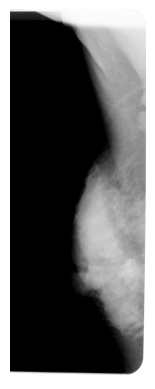

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
True Class: CIRCUMSCRIBED,ILL_DEFINED
Predicted Class: [['OBSCURED']]


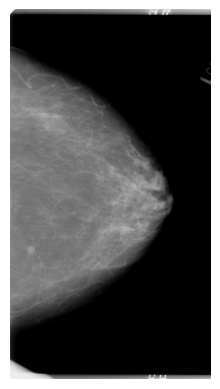

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
True Class: CIRCUMSCRIBED,ILL_DEFINED
Predicted Class: [['OBSCURED']]


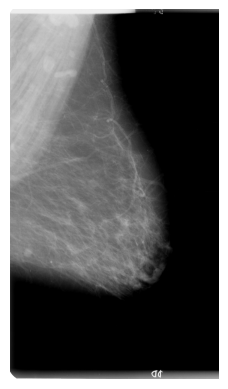

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
True Class: OBSCURED,OBSCURED
Predicted Class: [['ILL_DEFINED']]


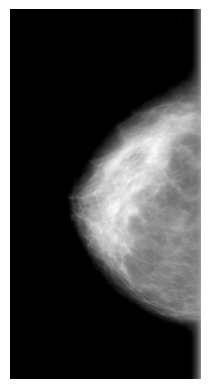

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
True Class: OBSCURED,OBSCURED
Predicted Class: [['ILL_DEFINED']]


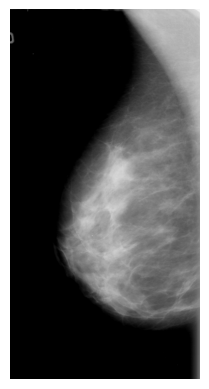

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
True Class: SPICULATED,SPICULATED
Predicted Class: [['OBSCURED']]


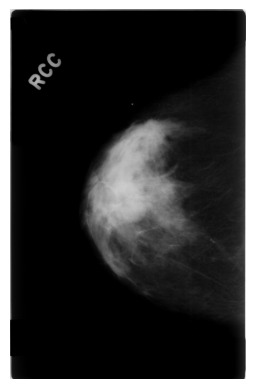

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
True Class: SPICULATED,SPICULATED
Predicted Class: [['OBSCURED']]


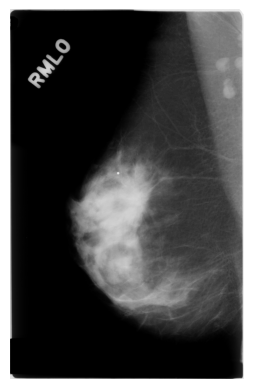

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
True Class: CIRCUMSCRIBED
Predicted Class: [['SPICULATED']]


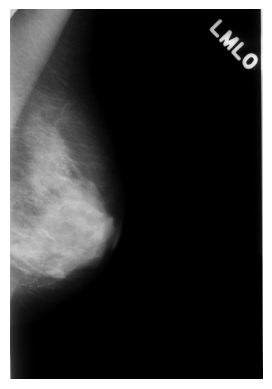

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
True Class: SPICULATED,SPICULATED
Predicted Class: [['ILL_DEFINED']]


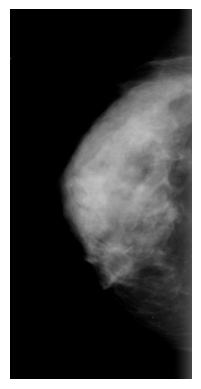

In [12]:
# Function to preprocess and load image
def preprocess_image(image_path):
   img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
   img = cv2.resize(img, (512, 512))
   img = img / 255.0  # Normalize
   img = np.expand_dims(img, axis=-1)  # Add channel dimension
   return img

# Select the first 5 images from mass_test_combined
test_images = mass_test_combined['image_file_path'].iloc[1:10]
true_classes = mass_test_combined['mass_margins'].iloc[1:10]
# Predict classes for each image
for image_path, true_class in zip(test_images, true_classes):
   # Preprocess image
   img = preprocess_image(image_path)
   # Make prediction
   pred = marginmodel.predict(np.array([img]))
   predictions=decode_predictions(pred)
   # Print true and predicted classes
   print("True Class:", true_class)
   print("Predicted Class:", predictions)
   # Load and display the image
   image = mpimg.imread(image_path)
   plt.imshow(image, cmap='gray')
   plt.axis('off')
   plt.show()

In [13]:
pred

array([[2.08959598e-02, 9.32500958e-01, 2.13438543e-04, 1.52216712e-03,
        5.76911494e-02, 1.15818686e-04]], dtype=float32)

In [ ]:
marginmodel.save('massmarginscodeas.keras')